# A Meta-Transfer Objective for Learning to Disentangle Causal Mechanisms

https://arxiv.org/pdf/1901.10912.pdf

## Knowing the correct causal model allows for efficient learning

We want to reproduce Figure A.1 in the paper and show that in a simple
probabilistic causal model with two variables $A$ and $B$, knowing
which one is conditioned of the other, that is knowing the correct
causal model, leads to a more efficient learning.

Specifically, consider $A$ and $B$, each taking $N$ possible values.
Depending on the causal mechanism, denoted $A \to B$ (A causes B) or 
$B \to A$ we have two models for estimating the joint probability:

$$
P_{A \to B}(A,B) = P_{A \to B}(A) P_{A \to B}(B | A) \\
P_{B \to A}(A,B) = P_{B \to A}(B) P_{B \to A}(A | B)
$$

Notice that there are $N + N^2$ parameters to represent the joint probability
in the case of discrete distributions. To cut things short, for $N=3$ we will
need to generate data from the following two distributions using [ancestral
sampling](https://ermongroup.github.io/cs228-notes/inference/sampling/#forward-sampling):

<table>
<tr><th>P(A) </th><th>P(B|A)</th></tr>
<tr><td>

| a1  | a2  | a3  |
|-----|-----|-----|
| .23 | .27 | .50 |

</td><td>

|   |b1   |b2   |b3   | 
|---|-----|-----|-----|
|a0 |.09  |.07  |.83  |
|a1 |.58  |.004 |.40  |
|a2 |.25  |.05  |.68  |

</td></tr> </table>

In this notebooks we will:

1. [learn to estimate the parameters of **P(X)** using SGD](#1.-Warmup.-Finding-the-parameters-of-the-Categorical-distribution),
2. [learn to estimate the parameters of **P(Y | X)** using SGD](#2.-Training-the-entire-model.),
3. [compare the sample complexity of the two possible causal models](#3.-We-are-now-in-a-position-to-generate-figure-A.1.).

Also, take a look at Apendix A for more details.

In [1]:
import torch
from torch.distributions import Categorical, Dirichlet

### 1. Warmup. Finding the parameters of the Categorical distribution

Remember one of the "modules" above, as the authors call them,
is $P(A)$. Let's try to estimate that one using SGD and the
parametrization proposed in the paper,
$P(X=i; \theta) = [\text{softmax}(\theta_A)]_i$.

In [2]:
N = 3
M = 1000
batch_size = 100

In [3]:
# Generate the data
π_A = Dirichlet(torch.ones(N)).sample().double()  # sample the parameters of the Categorical
pA = Categorical(π_A)
pA_samples = [pA.sample() for _ in range(M)]

Essentially our model with be just $\text{softmax}(\theta)$. Therefore:

$$
\begin{align}
    \log P(A=a | \theta) &= \log \frac{e^{\theta_{a}}}{\sum_i^{N} e^{\theta_i}} \\
                         &= \log e^{\theta_{a}} - \log \sum_i^{N} e^{\theta_i} \\
                         &= \theta_a - \log \sum_i^{N} e^{\theta_i}
\end{align}
$$

Our loss will then be $-\log P(A=a | \theta)$.

In [4]:
def log_p(a, θ):
    return θ[a] - torch.logsumexp(θ, dim=0)

In [5]:
# Configure the model
θ_A = torch.nn.Parameter(torch.zeros(N, dtype=torch.float64))

# And the optimizer
optim = torch.optim.RMSprop(params=[θ_A], lr=0.01)

print("target  θ: ", π_A)
print("initial θ: ", θ_A)

target  θ:  tensor([0.1761, 0.6135, 0.2104], dtype=torch.float64)
initial θ:  Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [6]:
# pass two times through the dataset
for i in range(1, 2 * M + 1):
    
    loss = - log_p(pA_samples[i % M], θ_A)
    loss.backward()
    
    if i % batch_size == 0:
        optim.step()
        optim.zero_grad()
    
        with torch.no_grad():
            err = torch.abs(torch.softmax(θ_A.data.unsqueeze(0), dim=1) - π_A).squeeze()
            err = ", ".join([f"{el.item():0.3f}" for el in err])
            print(f"[{i:5d}] loss: {loss.item():2.3f}, err: ", err)
            
print("\nReal params vs approximated params:")
print("θ_A", torch.softmax(θ_A.data.unsqueeze(0), dim=1).squeeze())
print("π_A", π_A)

[  100] loss: 1.099, err:  0.134, 0.234, 0.100
[  200] loss: 1.170, err:  0.124, 0.213, 0.089
[  300] loss: 1.204, err:  0.109, 0.185, 0.076
[  400] loss: 0.846, err:  0.091, 0.156, 0.065
[  500] loss: 0.782, err:  0.077, 0.136, 0.060
[  600] loss: 0.740, err:  0.069, 0.120, 0.052
[  700] loss: 0.707, err:  0.057, 0.106, 0.049
[  800] loss: 1.351, err:  0.052, 0.100, 0.048
[  900] loss: 1.478, err:  0.049, 0.096, 0.047
[ 1000] loss: 0.658, err:  0.050, 0.093, 0.043
[ 1100] loss: 1.486, err:  0.050, 0.087, 0.036
[ 1200] loss: 1.400, err:  0.053, 0.089, 0.036
[ 1300] loss: 1.472, err:  0.052, 0.081, 0.030
[ 1400] loss: 0.631, err:  0.044, 0.069, 0.024
[ 1500] loss: 0.607, err:  0.037, 0.061, 0.023
[ 1600] loss: 0.592, err:  0.034, 0.053, 0.019
[ 1700] loss: 0.580, err:  0.027, 0.046, 0.019
[ 1800] loss: 1.471, err:  0.025, 0.047, 0.022
[ 1900] loss: 1.605, err:  0.024, 0.048, 0.024
[ 2000] loss: 0.569, err:  0.027, 0.049, 0.023

Real params vs approximated params:
θ_A tensor([0.2029, 0.5

### 2. Training the entire model.

**Note:** In all these experiments the data will be generated
by the $A \to B$ causal model.

Our Probabilistical Graphical Model has only two nodes. We will
use ancestral sampling for sampling data from this conditional
distribution.

In [7]:
N = 3
train_steps = 1000
batch_size = 100

In [8]:
def ancestral_sampling(parent, child):
    """ We only have two nodes so our ancestral
    sampling routine is really simple. We sample
    a ~ P(A) and b ~ P(B|A=a).
    """
    a = parent.sample()
    b = child.sample()[a.item()]
    return torch.cat([a, b])

def get_dset(parent, child, M=1):
    return torch.stack([ancestral_sampling(parent, child) for _ in range(M)])

In [9]:
π_A = Dirichlet(torch.ones(1, N)).sample()
π_BA = Dirichlet(torch.ones(1, N)).sample((N,))

pA = Categorical(π_A)
pBA = Categorical(π_BA)

In [10]:
# generate a dataset (or batch) of size M
# with elements (a, b) where: a ~ P(A), b ~ P(B | A)
get_dset(pA, pBA, M=5)

tensor([[2, 0],
        [2, 0],
        [1, 2],
        [1, 2],
        [2, 2]])

Our model will be composed of the two possible
causal models outlined above and it will contain
parameters for four modules: $P(A), P(B), P(B|A)$
and $P(A|B)$.

In [11]:
class ConditionalModel(torch.nn.Module):
    def __init__(self, N, dtype=torch.float32):
        super(ConditionalModel, self).__init__()
        self.θ = torch.nn.Parameter(torch.zeros((1, N), dtype=dtype))   # params for P(A) or P(B)
        self.θ_yx = torch.nn.Parameter(torch.zeros((N,N), dtype=dtype)) # params for P(B|A) or P(A|B)
    
    def forward(self, x, y):
        # x can be a~A, b~B, y is the conditional.
        x = x.squeeze(1)
        y = y.squeeze(1)
        # compute log P(X=x)
        
        z_x = torch.logsumexp(self.θ, dim=1)
        log_pX = self.θ[0, x] - z_x
        
        # compute log P(Y=y | X=x)
        z_yx = torch.logsumexp(self.θ_yx[x], dim=1)
        log_pYX = self.θ_yx[x, y] - z_yx
    
        return log_pX + log_pYX

test_BA_model = ConditionalModel(4)
# compute P(B=3 | A=2)
test_BA_model(torch.tensor([[2]]), torch.tensor([[3]]))

tensor([-2.7726], grad_fn=<AddBackward0>)

In [12]:
# We want to find the following params:
print(π_A)
print(π_BA.squeeze())

tensor([[0.0247, 0.3202, 0.6550]])
tensor([[0.4444, 0.1638, 0.3919],
        [0.0464, 0.5581, 0.3955],
        [0.4241, 0.2185, 0.3574]])


In [13]:
model_BA = ConditionalModel(N)  # p(B|A) or A -> B
model_AB = ConditionalModel(N)  # p(A|B) or B -> A
model = torch.nn.ModuleList([model_BA, model_AB])

#Φ = list(model_BA.parameters()) + list(model_AB.parameters())
optim = torch.optim.RMSprop(model.parameters(), lr=0.01)

for i in range(1, train_steps+1):
    a, b = torch.split(get_dset(pA, pBA, M=batch_size), 1, dim=1)

    loss_BA = -torch.mean(model_BA(a, b))
    loss_AB = -torch.mean(model_AB(b, a))
    loss = loss_BA + loss_AB
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 100 == 0:
        print(f"[{i:4d}] loss_BA={loss_BA.item():2.3f}  |  loss_AB={loss_AB.item():2.3f} |  diff={(loss_BA-loss_AB).item():2.3f}")

[ 100] loss_BA=1.701  |  loss_AB=1.704 |  diff=-0.002
[ 200] loss_BA=1.844  |  loss_AB=1.849 |  diff=-0.005
[ 300] loss_BA=1.761  |  loss_AB=1.766 |  diff=-0.005
[ 400] loss_BA=1.704  |  loss_AB=1.706 |  diff=-0.002
[ 500] loss_BA=1.751  |  loss_AB=1.752 |  diff=-0.001
[ 600] loss_BA=1.837  |  loss_AB=1.836 |  diff=0.000
[ 700] loss_BA=1.750  |  loss_AB=1.749 |  diff=0.001
[ 800] loss_BA=1.571  |  loss_AB=1.571 |  diff=0.000
[ 900] loss_BA=1.679  |  loss_AB=1.678 |  diff=0.001
[1000] loss_BA=1.779  |  loss_AB=1.779 |  diff=0.000


In [14]:
# L1_distance(π, θ)
print(torch.abs(π_A - torch.softmax(model_BA.θ.data, dim=1)))
print(torch.abs(π_BA.squeeze() - torch.softmax(model_BA.θ_yx.data, dim=1)))

tensor([[0.0012, 0.0186, 0.0198]])
tensor([[0.0111, 0.0077, 0.0034],
        [0.0010, 0.0172, 0.0162],
        [0.0449, 0.0182, 0.0267]])


### 3. We are now in a position to generate figure A.1.

In [15]:
import time, datetime
import pandas as pd
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable(embed_options={'theme': 'fivethirtyeight'})

RendererRegistry.enable('default')

In [16]:
TRIALS = 10  # 100
Ns = [10, 30, 50]
M = 1000
batch_size = 100
device = torch.device('cpu') # small data, this is faster
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
columns = ['N', 'trial', 'step', 'diff']
df = pd.DataFrame(columns=columns)

In [18]:
for N in Ns:
    start = time.time()
    
    print(f"N={N}, trials: ", end="")
    for trial in range(TRIALS):
        # what will generate the data
        pA = Categorical(Dirichlet(torch.ones(1, N)).sample())
        pBA = Categorical(Dirichlet(torch.ones(1, N)).sample((N,)))
    
        # the models we will be training
        model_BA = ConditionalModel(N).to(device)  # p(B|A) or A -> B
        model_AB = ConditionalModel(N).to(device)  # p(A|B) or B -> A
        optim = torch.optim.RMSprop(
            torch.nn.ModuleList([model_BA, model_AB]).parameters(),
            lr=0.01
        )
    
        for step in range(M):
            a, b = torch.split(
                get_dset(pA, pBA, M=batch_size).to(device), 1, dim=1
            )

            loss_BA = -torch.mean(model_BA(a, b))
            loss_AB = -torch.mean(model_AB(b, a))
            loss = loss_BA + loss_AB
    
            optim.zero_grad()
            loss.backward()
            optim.step()
        
            with torch.no_grad():
                diff = (loss_AB - loss_BA).item()
            df = df.append(
                pd.DataFrame(data=[[N, trial, step, diff]], columns=columns),
                ignore_index=True
            )
            
        if trial == (TRIALS-1):
            elapsed = str(datetime.timedelta(seconds=time.time() - start))
            print(f"{trial}  |  time {elapsed}.", end="\n")
        else:
            print(f"{trial}, ", end="")

N=10, trials: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9  |  time 0:01:05.840469.
N=30, trials: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9  |  time 0:01:27.883137.
N=50, trials: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9  |  time 0:02:12.313122.


In [19]:
x_label = 'optimization steps'
y_label = 'log P(D|A→B) - log P(D|B→A)'

mean_plt = alt.Chart(df, width=720).mark_line().encode(
    x=alt.X('step', title=x_label),
    y=alt.Y('mean(diff)', title=y_label),
    color=alt.Color('N:O', scale=alt.Scale(scheme='set1'))
)

ci_plt = alt.Chart(df).mark_errorband(extent='ci').encode(
    x=alt.X('step', title=x_label),
    y=alt.Y('diff', title=y_label),
    color='N:O'
)

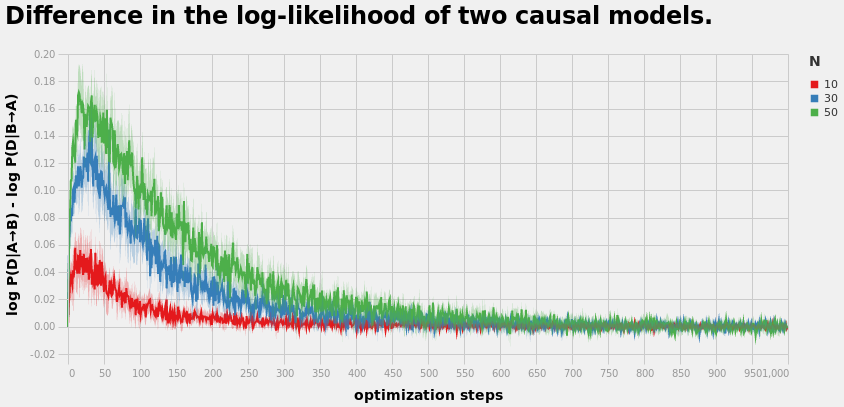

In [20]:
(mean_plt + ci_plt).properties(title="Difference in the log-likelihood of two causal models.")

#### Bibliography

1. https://arxiv.org/pdf/1901.10912.pdf
2. https://ermongroup.github.io/cs228-notes/inference/sampling/#forward-sampling